# Análisis espacio-temporal

En el notebook anterior hiucimos una análisis exploratorio básico de la estructura espacial pandemia en México. Ahora vamos a analizar con algo más de detalle la evolución espacio-temporal. Para hacerlo vamos a emplear técnicas que vienen del análisis regional, en general son técnicas para estudiar la convergencia en el desarrollo económico entre regiones. Sin embargo, aunque no estén nrelacionadas diréctamente con la epidemiología, las técnicas que vamos a usar resultan ilustrativas de cómo la epidemia evoluciona en el espacio.

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from libpysal.weights.contiguity import Queen
import giddy
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import glob
import splot
from splot.esda import moran_scatterplot
from esda.moran import Moran, Moran_Local, Moran_Local_BV
from splot.esda import lisa_cluster
from PIL import Image
import seaborn as sns
import sys
import contextily as ctx
plt.style.use('ggplot')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preproceso import get_confirmados_por_semana, get_defunciones_por_semana

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Vamos a realizar el análisis para la tasa de casos confirmados, porque ya vimos que tiene mayor estructura espacial. Empezamos por leer los datos y preprocesarlos (unir a población, sacar tasas)

In [134]:
confirmados_por_semana = get_confirmados_por_semana("../data/200624COVID19MEXICO.csv")
confirmados_por_semana = confirmados_por_semana.groupby(['municipio_cvegeo','FECHA_INGRESO'])[['acumulados']].sum()
confirmados_por_semana_wide = (confirmados_por_semana
                   .reset_index()
                   .pivot_table("acumulados", "municipio_cvegeo", "FECHA_INGRESO")
                  )
muns_geo = gpd.read_file("../data/municipios.gpkg")
confirmados_por_semana_wide = (confirmados_por_semana_wide
                   .merge(muns_geo, on='municipio_cvegeo', how='right')
                   .fillna(0))
confirmados_por_semana_wide.head()

,municipio_cvegeo,2020-01-19 00:00:00,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,2020-03-15 00:00:00,...,2020-05-31 00:00:00,2020-06-07 00:00:00,2020-06-14 00:00:00,2020-06-21 00:00:00,2020-06-28 00:00:00,_uid_,entidad_cvegeo,municipio_nombre,pob,geometry
0,01001,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,...,748.0,1004.0,1312.0,1572.0,1589.0,430,01,Aguascalientes,961977.0,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036..."
1,01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,11.0,18.0,23.0,23.0,431,01,Asientos,50864.0,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512..."
2,01003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,14.0,17.0,26.0,26.0,432,01,Calvillo,60760.0,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908..."
3,01004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,23.0,30.0,41.0,41.0,461,01,Cosío,16918.0,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875..."
4,01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,38.0,49.0,59.0,60.0,462,01,Jesús María,130184.0,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318..."


## Markov espacial

El primer análisis que vamos a hacer es ver la evolución de la epidemia como una cadena de Markov en la que el estado de cada municipio en un tiempo determinado es función de su estado en el tiempo previo (en este caso los momentos son semanas epidemiológicas) y el estado de los municipios vecinos. 

Las cadenas de Markov funcionan sobre estados discretos, mientras que nosotros tenemos datos continuos, entonces antes tenemos que _cuantizarlos_ de alguna forma. Un problema que se presenta aquí es que por la forma en la que la epidemia va creciendo, al principio hay poca variabilidad geográfica en el número (o la tasa) de casos, la mayoría son ceros. Entonces, para estudiar la epidemia con esta técnica, tenemos que empezar a partir de algún momento que nos permita _discretizar_ la tasa en algún número razonable de intervalos, digamos, por lo menos 4. Esto implica que no podemos realizar el análisis para toda la duración de la epidemia, solo de cierto momento en adelante.

Una vez que seleccionemos el número de clases (y por lo tanto el momento en el que vamos a iniciar el análisis), Markov espacial nos permite calcular la dinámica de las transiciones de clases condicionadas por el contexto local. La dinámica de las transiciones es dividida a lo largo de las diferentes clases a las que pertenezcan los vecinos. De esta forma, tendremos un régimen temporal para municipios cuyos vecinos estén en la clase más baja de casos confirmados, otra para los que tengan vecinos en la segunda clase y así sucesivamente.

Si pensamos que queremos 4 clases, entonces es a partir de la semana 12 que podemos segmentar los datos en cuartiles.

Primero, calculamos la matriz de pesos espaciales

In [57]:
confirmados_por_semana_wide = confirmados_por_semana_wide.drop([1286], axis=0) # quitamos Cozumel
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Obtenemos la matriz de datos (observaciones en filas, tiempo en columnas), calculamos las tasas y obtenemos el modelo de Markov espacial

In [77]:
y = confirmados_por_semana_wide.iloc[:,13:25].to_numpy(copy=True) # sacamos el array de los valores: una fila por observación, las variables en columnas
y = (y / confirmados_por_semana_wide['pob'].to_numpy().reshape(2456,1)) * 1000 # tasa por 1000 habitantes
sm = giddy.markov.Spatial_Markov(y, w, fixed=True, k=4, m=4) # spatial_markov instance o
sm.summary()

---------------------------------------------------
                Spatial Markov Test                
---------------------------------------------------
Number of classes: 4
Number of transitions: 27016
Number of regimes: 4
Regime names: LAG0, LAG1, LAG2, LAG3
---------------------------------------------------
   Test                   LR                Chi-2
  Stat.              417.815              413.946
    DOF                   18                   18
p-value                0.000                0.000
---------------------------------------------------
P(H0)           C0         C1         C2         C3
     C0      0.899      0.017      0.069      0.016
     C1      0.000      0.540      0.459      0.001
     C2      0.000      0.000      0.847      0.153
     C3      0.000      0.000      0.000      1.000
---------------------------------------------------
P(LAG0)         C0         C1         C2         C3
     C0      0.930      0.016      0.046      0.008
     C1      0.0

Lo que vemos en el resultado son las probabiliades de transición condicionadas al contexto local de los municipios. Cada LAG corresponde a una clasificación de los vecinos de los municipios en uno de los cuartiles: LAG0 el más bajo y LAG3 el más alto, más adelante vamos a visualizar estas probabilidades de una mejor forma. Por lo pronto lo importante es que la hipótesis nula (que el conytexto de los municipios no es importante) se rechaza debido a los valores de $LR$, $CHI-2$ y sus respectivos $p-values$.

Para ver mejor el resultado del modelo, hagamos _heatmaps_ con las matrices de transición

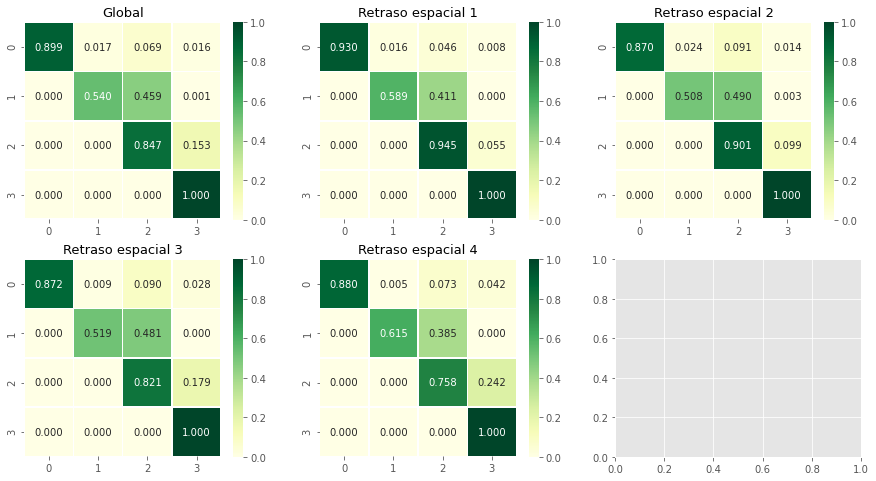

In [84]:
fig, axes = plt.subplots(2,3,figsize = (15,8)) 

for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if i==0 and j==0:
            im = sns.heatmap(sm.p, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                          square=True, cmap="YlGn",fmt='.3f')
            ax.set_title("Global",fontsize=13) 
        else:
            if i*3+j-1 < 4:
                p_temp = sm.P[i*3+j-1]
                im = sns.heatmap(p_temp, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                              square=True, cmap="YlGn",fmt='.3f')
                ax.set_title("Retraso espacial %d"%(i*3+j),fontsize=13)
            else:
                pass
                

El primer _heatmap_ representa la matriz global de transiciones, sin considerar el contexto. Las siguientes matrices son las transiciones _condicionadas_ al estado de los municipios vecinos.

Lo primero que podemos ver es que siempre que un municipio esté en el cuartil más alto, va a permancer ahí independientemente del estado de sus vecinos. De hecho, no se observan transiciones hacia los cuartiles más bajos, lo que evidencía que, globalmente, la epidemia sigue en crecimiento.

Otra cosa interesante es que para los municipios en el cuartil más bajo, el estado de los vacinos produce transiciones hacia los cuartiles 2 y 3. No parece haber evidencia de que los municipios en el cuartil 1 vean afectadsas sus transiciones al segundo cuartil, pero sí para los que están el el cuertil 2 que aumentan la probabilidad de subir al 3 conforme sus vecinos tienen mayores tasas.

De alguna forma estos resultados, son un poco contraintuitivos, uno esperaría ver algunas transiciones hacia abajo y una mayor probabilidad de subir para los municipios más bajos. Quizá lo que estamos viendo es en parte conseuencia de la forma en la que cuantizamos los datos. Usar `Fixed=True` calcula los cuartiles tomando los datos de las $n*t$ observaciones, alternativamente, podemos cuantizar utilizando ínicamente las observaciones en cada tiempo. Noten que para esto vamos a tomar una semana menos 

In [86]:
y = confirmados_por_semana_wide.iloc[:,14:25].to_numpy(copy=True) # sacamos el array de los valores: una fila por observación, las variables en columnas
y = (y / confirmados_por_semana_wide['pob'].to_numpy().reshape(2456,1)) * 1000 # tasa por 1000 habitantes
sm_r = giddy.markov.Spatial_Markov(y, w, fixed=False, k=4, m=4) # spatial_markov instance o
sm_r.summary()

---------------------------------------------------
                Spatial Markov Test                
---------------------------------------------------
Number of classes: 4
Number of transitions: 24560
Number of regimes: 4
Regime names: LAG0, LAG1, LAG2, LAG3
---------------------------------------------------
   Test                   LR                Chi-2
  Stat.              661.324              686.968
    DOF                   24                   24
p-value                0.000                0.000
---------------------------------------------------
P(H0)           C0         C1         C2         C3
     C0      0.897      0.054      0.041      0.008
     C1      0.000      0.780      0.206      0.014
     C2      0.000      0.116      0.763      0.121
     C3      0.000      0.000      0.075      0.925
---------------------------------------------------
P(LAG0)         C0         C1         C2         C3
     C0      0.945      0.030      0.019      0.007
     C1      0.0

El modelo sigue siendo estadísticamente significativo

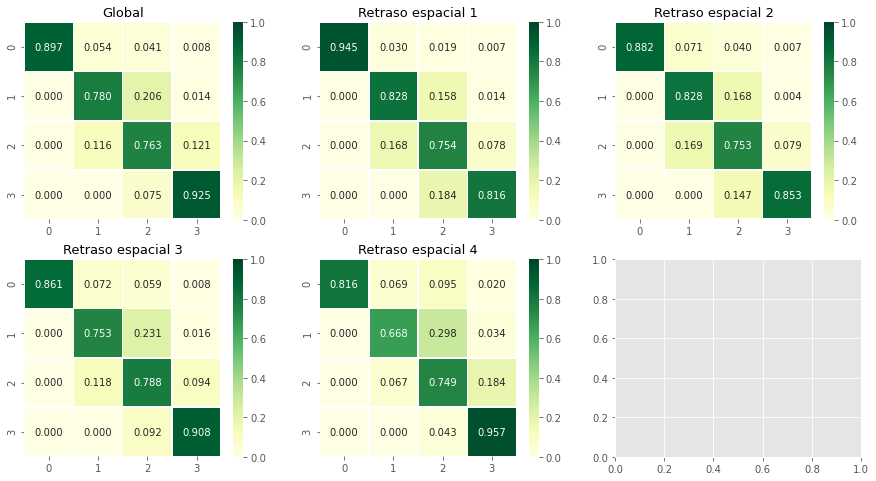

In [87]:
fig, axes = plt.subplots(2,3,figsize = (15,8)) 

for i in range(2):
    for j in range(3):
        ax = axes[i,j]
        if i==0 and j==0:
            im = sns.heatmap(sm_r.p, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                          square=True, cmap="YlGn",fmt='.3f')
            ax.set_title("Global",fontsize=13) 
        else:
            if i*3+j-1 < 4:
                p_temp = sm_r.P[i*3+j-1]
                im = sns.heatmap(p_temp, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                              square=True, cmap="YlGn",fmt='.3f')
                ax.set_title("Retraso espacial %d"%(i*3+j),fontsize=13)
            else:
                pass
                

Estos resultados tienen mucho más sentido. Por ejemplo, globalmente, la probabilidad de pasar del cuartil más bajo al siguiente es 0.054, sin embargo, condicionada a que sus vecinos esten en el tercer cuartil es de 0.072. En el sentido contrario, la probabilidad de permanecer en el cuartil más alto es más baja cuando los vecinos se encuentran en el cuartil más bajo.

## LISA Markov

Finalmente, una alternativa es utilizar como discretización los cuadrantes de LISA para las observaciones a nivel municipio. Tomemos, por ejemplo, el diagrama de dispersión de Moran para la última semana 

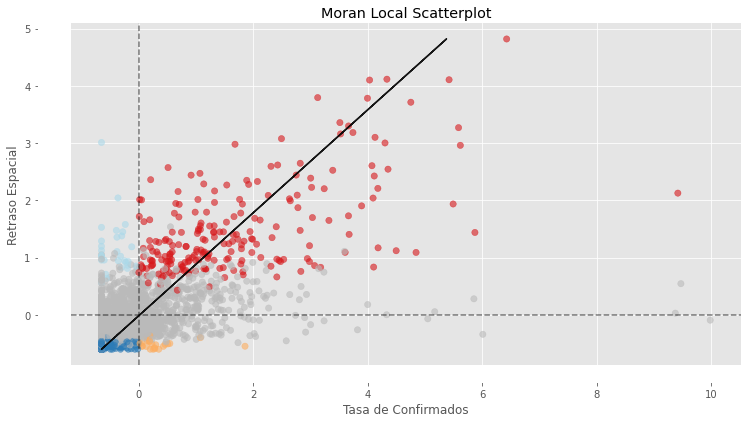

In [106]:
ultima_confirmados = confirmados_por_semana_wide[[pd.to_datetime('2020-06-28'), 'municipio_cvegeo', 'geometry', 'pob']].copy()
ultima_confirmados['tasa'] = (ultima_confirmados[pd.to_datetime('2020-06-28')] / ultima_confirmados['pob'])*1000
local_moran = Moran_Local(ultima_confirmados['tasa'].to_numpy(), w, permutations=1000)
fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = moran_scatterplot(local_moran, p=0.05, ax=ax)
ax.set_xlabel('Tasa de Confirmados')
ax.set_ylabel('Retraso Espacial')
plt.show()

El diagrama de dispersión de Moran nos muestra la dispersión de los valores de la variable de interés para cada observación contra el promedio de sus vecinos. Los cuatro cuadrantes (líneas punteadas) definen el tipo de cluster: 

* HH: arriba a la izquierda
* LL: abajo a la izquierda 
* LH: abajo a la derecha
* HL: arriba a la izquierda

Entonces, para cada momento en el tiempo, cada observación queda clasificada en alguno de esos cuadrantes, lo que nos da una cuantización alternativa de los datos que incluye ya la información del contexto geográfico.

Primero ajustamos el modelo y vemos si es significativo.

**Nota:** vamos a usar menos semanas para quedarnos con semanas que tengan cantidades importantes de conglomerados significativos

In [115]:
y = confirmados_por_semana_wide.iloc[:,14:25].to_numpy(copy=True) # sacamos el array de los valores: una fila por observación, las variables en columnas
y = (y / confirmados_por_semana_wide['pob'].to_numpy().reshape(2456,1)) * 1000 # tasa por 1000 habitantes
lm = giddy.markov.LISA_Markov(y, w, permutations=1000)
"Chi2: %8.3f, p: %5.2f, dof: %d" % lm.chi_2

'Chi2: 7278.531, p:  0.00, dof: 9'

Estamos ajustando el modelo para las últimas 11 semanas y de acuerdo a los valores de $Chi^2$ y de $p$ es calro que se descarta la hipótesis de que las trancisiones no dependen del retraso espacial.

Veamos entonces la matriz de transiciones

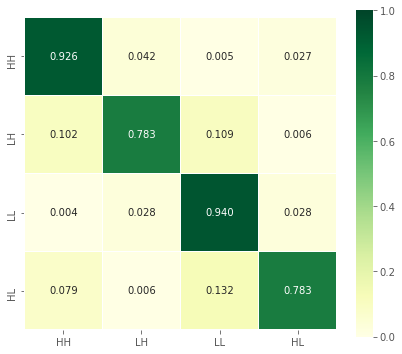

In [116]:
fig, ax = plt.subplots(figsize = (7,6))
im = sns.heatmap(lm.p, annot=True, linewidths=.5, ax=ax, cbar=True, vmin=0, vmax=1,
                 square=True,  cmap="YlGn",fmt='.3f', xticklabels=['HH', 'LH', 'LL', 'HL'],
                 yticklabels=['HH', 'LH', 'LL', 'HL'])

La diagonal domina las probabilidades, es decir, la evolución es relativamente estable en lo espacial. Sin embargo es interesante ver que tanto los LH como los HL son menos estables. Para los LH la probabilidad de pasar a HH o a LL es casi igual, sin embargo para los HL sí es bastante más probable pasar a LL. Esto nos dice que los municipios que están en mayor riesgo son en definitiva los LH. Para darnos una idea de cuáles son, veamos una vez más el mapa para la última semana

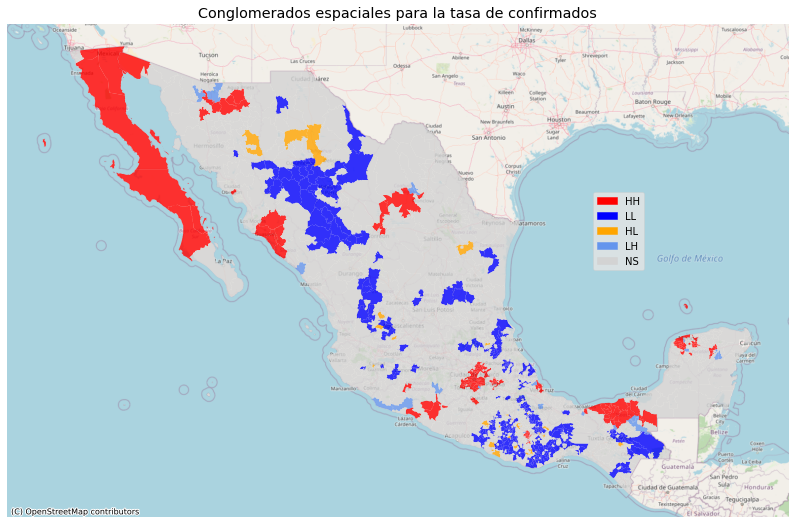

In [119]:
lisa_confirmados = Moran_Local.by_col(ultima_confirmados.drop(pd.to_datetime('2020-06-28'), axis=1),'tasa',  w, permutations=10000, outvals=['q'])
# lisa_ultima = lisa_ultima.loc[:,['municipio_cvegeo', 'geometry', 'tasa,', 'tasa_p_sim', 'tasa_q']]
lisa_confirmados.rename({'tasa_q': 'cluster'}, inplace=True, axis=1)
lisa_confirmados.loc[lisa_confirmados['tasa_p_sim'] >= 0.5, 'cluster'] = -4
lisa_confirmados = gpd.geodataframe.GeoDataFrame(lisa_confirmados)
lisa_confirmados.crs = 'EPSG:4326'
lisa_confirmados['cluster'] = lisa_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
lisa_confirmados.head()
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in lisa_confirmados.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados espaciales para la tasa de confirmados')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

In [98]:
lm.significant_moves

array([[64, 64, 64, ..., 64, 64, 64],
       [54, 54, 54, ..., 54, 54, 54],
       [57, 49, 49, ..., 59, 59, 59],
       ...,
       [59, 59, 59, ..., 59, 59, 59],
       [59, 59, 59, ..., 59, 59, 59],
       [59, 58, 55, ..., 59, 59, 59]])

## Efectos de difusión (spillover)

In [120]:
spillover = lm.spillover()
components_df = pd.DataFrame(spillover['components'])
cols = ['component_t_' + str(c) for c in components_df.columns]
components_df.columns = cols
spillover_df = pd.DataFrame(spillover['spill_over'])
cols = ['spillover_t_' + str(c +1) for c in spillover_df.columns]
spillover_df.columns = cols
spillover_df.head()

,spillover_t_1,spillover_t_2,spillover_t_3,spillover_t_4,spillover_t_5,spillover_t_6,spillover_t_7,spillover_t_8,spillover_t_9,spillover_t_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
